# Air Quality MOSM

Experiment on mosm 

Autor: Alejandro Cuevas A.

##  Notes on the use of the toolbox
* comment the code only if unexpected

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


%reload_ext autoreload
%autoreload 2

In [2]:
os.makedirs('output', exist_ok=True)

In [3]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

2. __CO(GT)__ True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. __PT08.S1(CO)__ PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. __NMHC(GT)__ True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. __C6H6(GT)__ True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. __PT08.S2(NMHC)__ PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. __NOx(GT)__ True hourly averaged NOx concentration in ppb (reference analyzer)
8. __PT08.S4(NO2)__ PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. __NO2(GT)__ True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. __PT08.S4(NO2)__ PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. __PT08.S5(O3)__ PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. __T__ Temperature in Â°C
13. __RH__ Relative Humidity (%)
14. __AH__ AH Absolute Humidity 

__Load and Pre-processing__

In [4]:
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# last 2 columns are only nans
df = df.iloc[:, :-2]

# drop the rows with nan values
df.dropna(inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
dates = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# create column with datetime values
df['timedate'] = dates

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['time'] = (dates - ini_date) / pd.Timedelta(hours=1)

# drop useless columns
df.drop(columns=['Time', 'Date'], inplace=True)

In [5]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,timedate,time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22.0


We check the number of missing values per column, registered as -200 (minimun value of the sensor)

In [6]:
(df == -200).sum(0)

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
timedate            0
time                0
dtype: int64

### MOSM data structure

MOGP toolbox uses the following structure:
Given $m$ channels, each one with its inputs $x_i$ and output $y_i$, $i=1,\ldots,m$. The toolbox uses to train

* list of inputs $x$.
* list of outputs $y$.
* Number of components $Q$

### Data to use

* As outputs we will use the ground thruth of: CO, NMHC, C6H6, NOx, NO2
* I a first experiment will only use time as input.

In [7]:
# we use the first 200 rows, the first 3 days
n_experiment = 200
ini_t = 300
df2 = df.iloc[ini_t:n_experiment + ini_t]

In [8]:
# fix random seed
# np.random.seed(3)

# columns to use
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# class for storing data
data = mogptk.Data()

for i, c in enumerate(cols):
    # index of non-missing values
    idx = (df2[c] != -200)
    
    print('Channel {} with {} non-missing values'.format(c, idx.sum()))
    
    # add data to the model
    x = df2['time'][idx].values
    y = df2[c][idx].values
    
    data.add(x, y)

print('Points per channel:', data.get_channel_sizes())

Channel CO(GT) with 196 non-missing values
Channel NMHC(GT) with 200 non-missing values
Channel C6H6(GT) with 200 non-missing values
Channel NOx(GT) with 192 non-missing values
Channel NO2(GT) with 192 non-missing values
Points per channel: [196, 200, 200, 192, 192]


In [9]:
# randomly sample from the data
for i in range(5):
    data.remove_randomly(channel=i, pct=0.7)

# drop chunks to simulate sensor failure
data.remove_range(0, 425, 460)
data.remove_range(1, 480, None)
data.remove_range(2, 480, None)
data.remove_range(3, 480, None)
data.remove_range(4, None, 350)

In [10]:
def plot_air_experiment(x_train=None,
                        y_train=None,
                        df_full=None,
                        x_pred=None,
                        y_pred=None,
                        var_pred=None,
                        ylims=None,
                        cols=cols,
                        title=''):
    """
    5x1 Plot for the Air quality experiment
    """
    if ylims is None:
        ylims = [(-1, 7), (-60, 900), (-5, 32), (-50, 380), (10, 170)]
        
    f, axarray = plt.subplots(5, 1, sharex=True, figsize=(12, 10))

    for i in range(5):
        # plot post mean
        if (x_pred is not None) & (y_pred is not None):
            axarray[i].plot(x_pred[i] ,y_pred[i], label='Post.Mean', c=sns.color_palette()[i])
            
        # error bars
        if (x_pred is not None) & (y_pred is not None) & (var_pred is not None):
            axarray[i].fill_between(x_pred[i],
                                    y_pred[i] + 2 * np.sqrt(var_pred[i]),
                                    y_pred[i] - 2 * np.sqrt(var_pred[i]),
                                    alpha=0.3,
                                    label='95% c.i.',
                                    color=sns.color_palette()[i]
                                   )
        # plot trainning points
        if (x_train is not None) & (y_train is not None):
            axarray[i].plot(x_train[i], y_train[i], '.k', ms=6, label='Training points')
            
        # plot ground truth will all data
        if df_full is not None:
            idx = df_full[cols[i]]!= -200
            axarray[i].plot(df2['time'][idx], df2[cols[i]][idx], '--k', label='All data', alpha=0.7)

        axarray[i].set_ylabel(cols[i][:-4])
        axarray[i].set_ylim(ylims[i])

    plt.legend(fontsize=12, ncol=4, bbox_to_anchor=(0.35, 5.65, 0.5, 0.5))
    plt.xlabel('Hours')
    plt.xlim(df2['time'].values[0] - 1, df2['time'].values[-1] + 1)
    plt.suptitle(title, y=0.95)

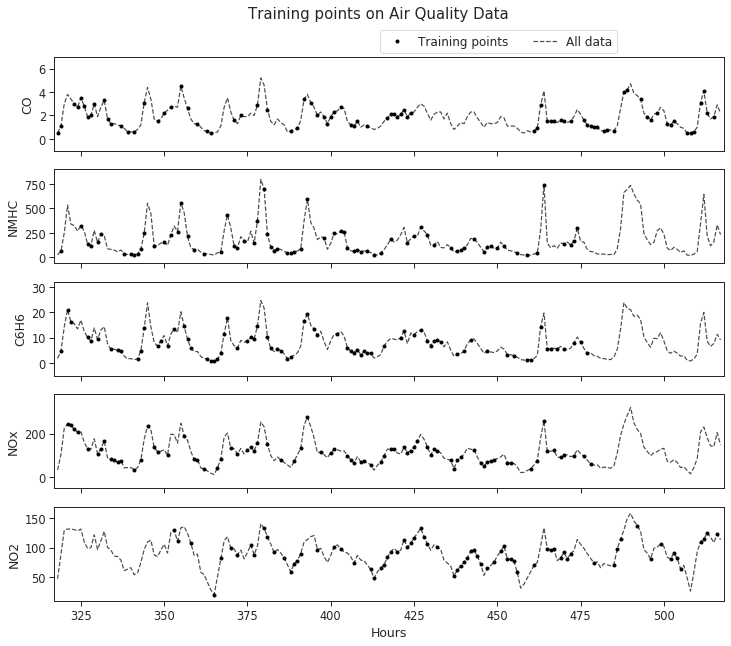

In [11]:
title='Training points on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    df_full=df2,
                    title=title
                   )

__Define model__

In [12]:
model_mosm = mogptk.MOSM(data, Q=4)
model_mosm.estimate_means()
model_mosm.build()

__Optimice__

In [14]:
# optimizers: 'adam', 'L-BFGS-B'
model_mosm.optimize(optimizer='Adam', maxiter=3000, learning_rate=0.001)

Optimizing...
Done


__Predict on all hours__

In [38]:
n_res = 500
model_mosm.set_prediction_range(0, df2['time'].values[0], df2['time'].values[-1], n=n_res)
model_mosm.set_prediction_range(1, df2['time'].values[0], df2['time'].values[-1], n=n_res)
model_mosm.set_prediction_range(2, df2['time'].values[0], df2['time'].values[-1], n=n_res)
model_mosm.set_prediction_range(3, df2['time'].values[0], df2['time'].values[-1], n=n_res)
model_mosm.set_prediction_range(4, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_mosm.predict()

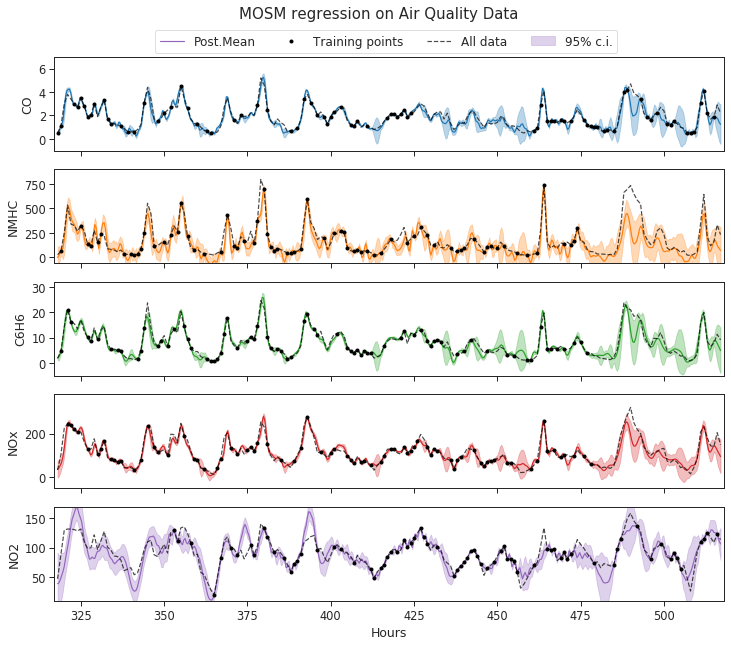

In [39]:
title = 'MOSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    df_full=df2,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
plt.savefig('output/air_quality_mosm.pdf', bbox_inches='tight')

### Get MAE

Mean absolute error per channel

In [88]:
x_pred = {i:array for i, array in enumerate(data.X_all)}
model_mosm.set_prediction_x(x_pred)

In [89]:
# predict
x_pred, y_pred, var_pred = model_mosm.predict()

__MAE__

Mean absolute error per channel

In [90]:
# obtain MAE
for i, c in enumerate(cols):
    idx = df2[c] != -200
    error = np.abs(df2[c][idx].values - y_pred[i]).mean()
    # print('Mae for channel {} = {}'.format(i, error))
    print(error)

0.1691371099288478
48.53479779137602
0.9136189689905996
12.03121553837241
8.668174040831088


__MAPE__

Mean absolute porcentual error

In [91]:
# obtain MAPE
for i, c in enumerate(cols):
    idx = df2[c] != -200
    error = np.abs((df2[c][idx].values - y_pred[i]) / df2[c][idx].values * 100).mean()
    # print('Mae for channel {} = {}'.format(i, error))
    print(error)

9.704872963720689
38.36742880417248
18.811271589176748
12.607881969409709
10.436433238115617


__MSE__

Mean squared error per channel

In [95]:
# obtain MSE
for i, c in enumerate(cols):
    idx = df2[c] != -200
#     error = ((df2[c][idx].values - y_pred[i])**2).mean()
    error = ((data.Y_all[i] - y_pred[i])**2).mean()
    print(error)

0.10965494947788178
8449.616449843312
2.7692129867738062
498.20727763251625
212.08204530890825


# Independant GP with SM kernel (IGP)

__Create kernel__

In [30]:
from spectralmixture import SpectralMixture, sm_init
import gpflow

__instanciate model and train__

In [31]:
# fix random seed
np.random.seed(1)

# Spectral Mixture kernel
Q = 4 # nnumber of mixtures
D = 1  # input dim

# prediction inputs
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500).reshape(-1, 1)

mean_list = []
std_list = []

# metric containers
mae_total = np.zeros(5)
mse_total = np.zeros(5)

for i in range(5):
    model_list = [] # model list
    X = x_train[i].reshape(-1, 1)
    Y = y_train[i].reshape(-1, 1)
    
    # first get the sm kernel params set
    weights, means, scales = sm_init(train_x=X, train_y=Y, num_mixtures=Q)
    k_sm = SpectralMixture(mixture_weights=weights,mixture_scales=scales, mixture_means=means,input_dim=1)
    
    # create model
    m = gpflow.models.GPR(X, Y, kern=k_sm)
        
    # train
    gpflow.training.AdamOptimizer(0.01).minimize(m, maxiter=5000)
    print('Model {} finished training!'.format(i))
    
    # predict
    mean, var = m.predict_y(x_pred)
    
    mean_list.append(mean)
    std_list.append(np.sqrt(var))
    
    # ERROR METRICS
    # predict on all data input 
    
    # generate inputs in the same points as the training set
    idx = df2[cols[i]] != -200
    X_pred = df2['time'][idx].values.reshape(-1, 1)
    mean, var = m.predict_y(X_pred)
    
    diff = mean - df2[cols[i]][idx].values
    
    mae_total[i] = np.abs(diff).mean()
    mse_total[i] = (diff**2).mean()

Using default mixture = 1
Model 0 finished training!
Using default mixture = 1
Model 1 finished training!
Using default mixture = 1
Model 2 finished training!
Using default mixture = 1
Model 3 finished training!
Using default mixture = 1
Model 4 finished training!


In [35]:
print(mae_total)

[  0.80134785 151.67705617   5.65028272  62.20005965  25.02591287]


In [36]:
print(mse_total)

[9.88714075e-01 4.59179756e+04 5.32384615e+01 6.46692782e+03
 1.00699126e+03]


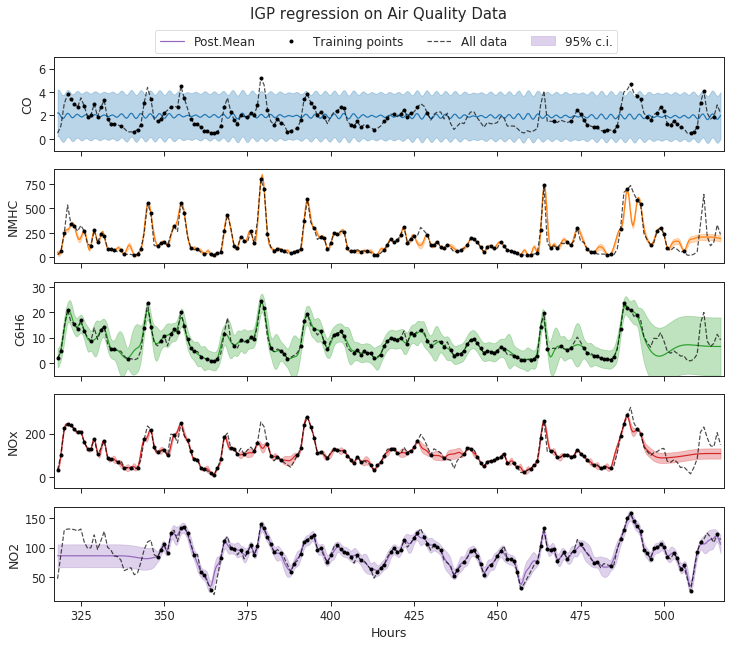

In [34]:
f, axarray = plt.subplots(5, 1, sharex=True, figsize=(12, 10))

for i in range(5):
    # plot post mean
    axarray[i].plot(x_pred, mean_list[i].reshape(-1), label='Post.Mean', c=sns.color_palette()[i])
    # error bars
    axarray[i].fill_between(x_pred.reshape(-1),
                            mean_list[i].reshape(-1) + 2 * std_list[i].reshape(-1),
                            mean_list[i].reshape(-1) - 2 * std_list[i].reshape(-1),
                            alpha=0.3,
                            label='95% c.i.',
                            color=sns.color_palette()[i]
                           )
    # plot trainning points
    axarray[i].plot(x_train[i], y_train[i], '.k', ms=6, label='Training points')
    # plot ground truth will all data
    idx = df2[cols[i]]!= -200
    axarray[i].plot(df2['time'][idx], df2[cols[i]][idx], '--k', label='All data', alpha=0.7)
    
    axarray[i].set_ylabel(cols[i][:-4])
    axarray[i].set_ylim(ylims[i])

plt.legend(fontsize=12, ncol=4, bbox_to_anchor=(0.35, 5.65, 0.5, 0.5))
plt.xlabel('Hours')
plt.xlim(df2['time'].values[0] - 1, df2['time'].values[-1] + 1)
plt.suptitle('IGP regression on Air Quality Data', y=0.95)
plt.savefig('img/air_quality_igp.pdf', bbox_inches='tight')

In [43]:
mse_total[4]

1006.9912629125257